In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.window import Window
from pyspark.sql import SparkSession 
import pyspark.sql.functions as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = 'gs://bkt-dataproc-prod-eu-notebookmatthieubritoantunes/google-merchant-centre/'
filename = 'top_products_gmc_10_2020.parquet'

df_merchant = sqlContext.read.load(path+filename)
df_merchant = (df_merchant.withColumnRenamed('product_category', 'large_product_category')
               .withColumn('product_category', 
                           F.split(F.col('large_product_category'), ' > ').getItem(0))
              ).distinct()
df_merchant.cache().count()

67837306

In [3]:
#Work carried on on UK data as a first example
df_merchant_uk_ = df_merchant.filter(F.col('country')=='GB')
df_merchant_uk_.cache().count()

10268572

In [4]:
df_merchant_uk = (df_merchant_uk_.groupBy(F.col('date'),
                                          F.col('product_name'),
                                          F.col('product_brand'),
                                          F.col('product_category'))
                  .agg(F.mean(F.col('product_rank')).cast(IntegerType()).alias('product_rank'),
                       F.max(F.col('product_price')).alias('product_price'))
                  .orderBy(F.asc('date'),
                           F.asc('product_brand'),
                           F.asc('product_category'),
                           F.asc('product_name'))
                  .select(F.col('date'),
                          F.col('product_name'),
                          F.col('product_brand'),
                          F.col('product_category'),
                          F.col('product_price'),
                          F.col('product_rank'),
                          F.lag('product_rank',1).over(Window.partitionBy('product_name')
                                                       .orderBy('date'))
                          .alias('previous_product_rank')
                         )
                 )
df_merchant_uk.cache().count()

3517591

In [5]:
del df_merchant_uk_

In [6]:
df_merchant_uk.limit(5).toPandas()

,date,product_name,product_brand,product_category,product_price,product_rank,previous_product_rank
0,2020-10-09,"""KODAK Cherish C525 Video Baby Monitor",Kodak,Baby & Toddler,160.5,828,NaN
1,2020-10-10,"""KODAK Cherish C525 Video Baby Monitor",Kodak,Baby & Toddler,160.5,857,828.0
2,2020-10-11,"""KODAK Cherish C525 Video Baby Monitor",Kodak,Baby & Toddler,160.5,898,857.0
3,2020-10-12,"""KODAK Cherish C525 Video Baby Monitor",Kodak,Baby & Toddler,160.5,874,898.0
4,2020-10-13,"""KODAK Cherish C525 Video Baby Monitor",Kodak,Baby & Toddler,160.5,828,874.0


# Pricing and Catalogue Time

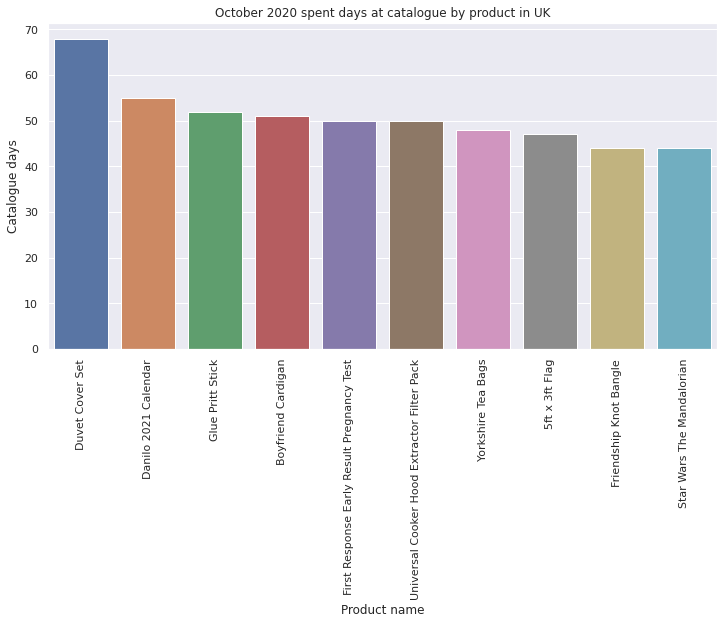

In [12]:
product_catalogue_days = (df_merchant_uk.groupBy('product_name')
                          .agg(F.count('date').alias('catalogue_days'))
                          .orderBy(F.desc('catalogue_days'))
                          .select(F.col('product_name'),
                                  F.col('catalogue_days'))
                          .orderBy(F.desc('catalogue_days'))
                          .toPandas()
                         )

import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize': (12, 6)})

ax = sns.barplot(x='product_name', y='catalogue_days', data=product_catalogue_days[:10])
ax.set(title='October 2020 spent days at catalogue by product in UK',
       xlabel='Product name', 
       ylabel='Catalogue days')
plt.xticks(rotation=90);
plt.show()

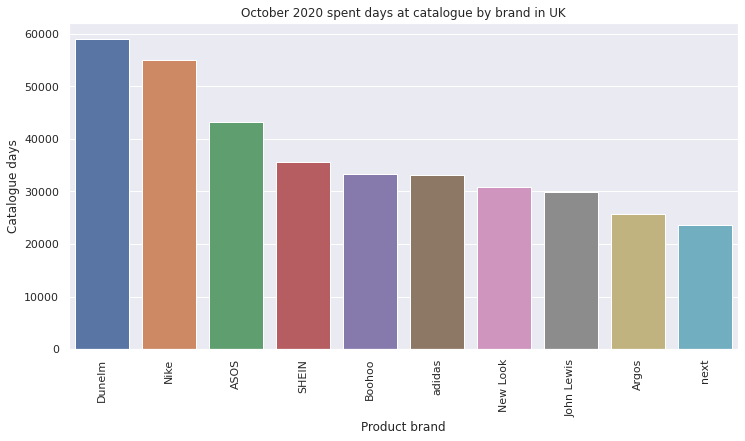

In [13]:
brand_catalogue_days = (df_merchant_uk.groupBy('product_brand')
                          .agg(F.count('date').alias('catalogue_days'))
                          .orderBy(F.desc('catalogue_days'))
                          .select(F.col('product_brand'),
                                  F.col('catalogue_days'))
                          .orderBy(F.desc('catalogue_days'))
                          .toPandas()
                         )

import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize': (12, 6)})

ax = sns.barplot(x='product_brand', y='catalogue_days', data=brand_catalogue_days[:10])
ax.set(title='October 2020 spent days at catalogue by brand in UK',
       xlabel='Product brand', 
       ylabel='Catalogue days')
plt.xticks(rotation=90);
plt.show()

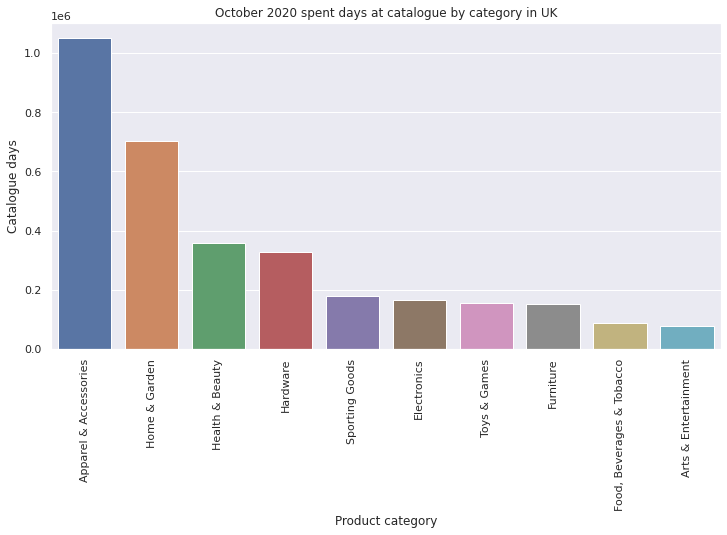

In [24]:
category_catalogue_days = (df_merchant_uk.groupBy('product_category')
                           .agg(F.count('date').alias('catalogue_days'))
                           .select(F.col('product_category'),
                                   F.col('catalogue_days'))
                           .orderBy(F.desc('catalogue_days'))
                           .toPandas()
                          )

ax = sns.barplot(x='product_category', y='catalogue_days', data=category_catalogue_days[:10])
ax.set(title='October 2020 spent days at catalogue by category in UK',
       xlabel='Product category', 
       ylabel='Catalogue days')
plt.xticks(rotation=90);
plt.show()

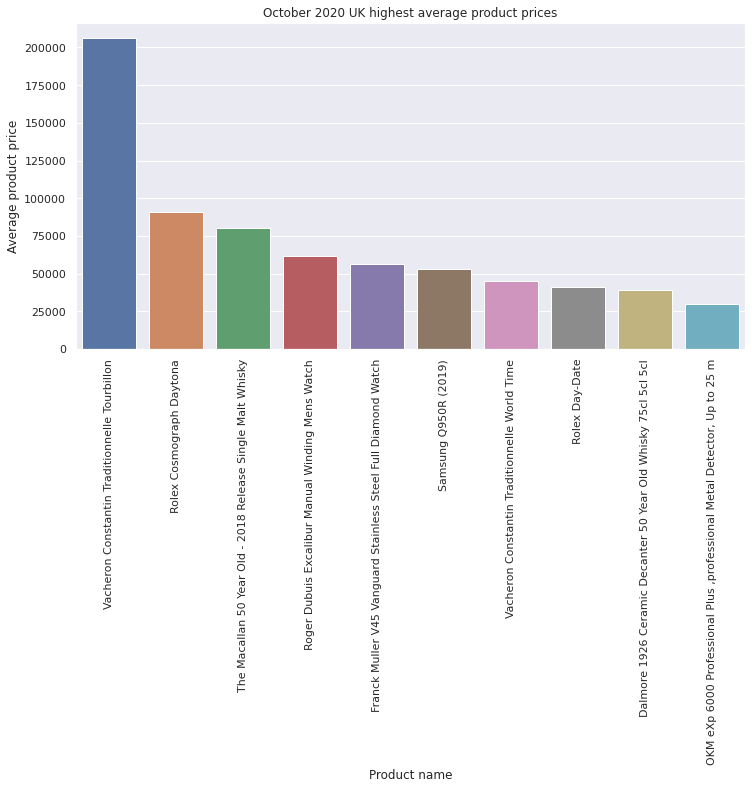

In [20]:
product_price = (df_merchant_uk.groupBy('product_name')
                 .agg(F.mean('product_price').alias('average_product_price'))
                 .select(F.col('product_name'),
                         F.col('average_product_price'))
                 .orderBy(F.desc('average_product_price'))
                 .toPandas()
                )

ax = sns.barplot(x='product_name', y='average_product_price', data=product_price[:10])
ax.set(title='October 2020 UK products with highest average prices',
       xlabel='Product name', 
       ylabel='Average product price')
plt.xticks(rotation=90);
plt.show()

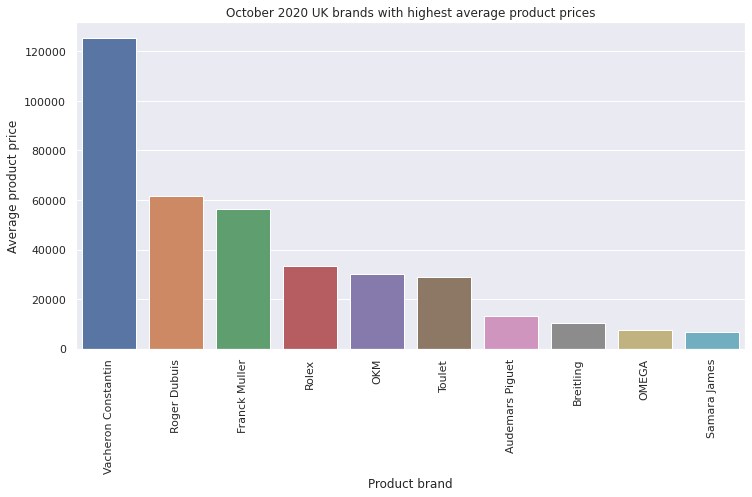

In [21]:
brand_price = (df_merchant_uk.groupBy('product_brand')
               .agg(F.mean('product_price').alias('average_product_price'))
               .select(F.col('product_brand'),
                       F.col('average_product_price'))
               .orderBy(F.desc('average_product_price'))
               .toPandas()
              )

ax = sns.barplot(x='product_brand', y='average_product_price', data=brand_price[:10])
ax.set(title='October 2020 UK brands with highest average product prices',
       xlabel='Product brand', 
       ylabel='Average product price')
plt.xticks(rotation=90);
plt.show()

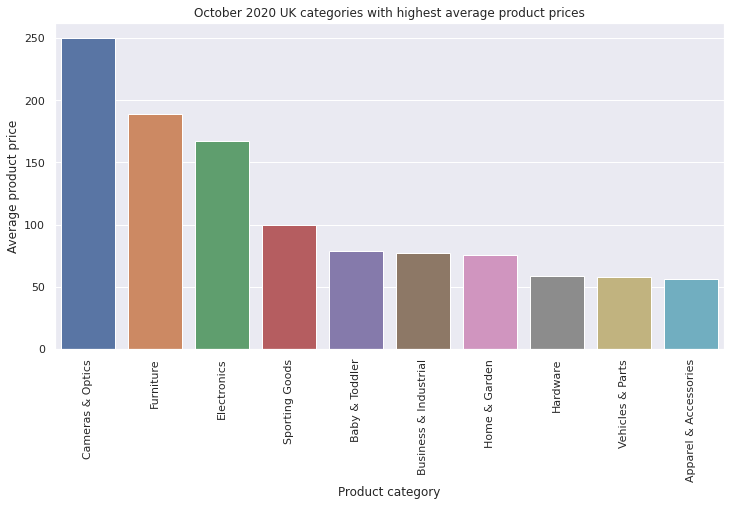

In [25]:
category_price = (df_merchant_uk.groupBy('product_category')
                  .agg(F.mean('product_price').alias('average_product_price'))
                  .select(F.col('product_category'),
                          F.col('average_product_price'))
                  .orderBy(F.desc('average_product_price'))
                  .toPandas()
                 )

ax = sns.barplot(x='product_category', y='average_product_price', data=category_price[:10])
ax.set(title='October 2020 UK categories with highest average product prices',
       xlabel='Product category', 
       ylabel='Average product price')
plt.xticks(rotation=90);
plt.show()

# Pricing, Ranking Evolution and Rising Stars

# Latest k

# Upcoming Trends